In [1]:
import numpy as np
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers


from PIL import Image
import glob

import matplotlib.pyplot as plt


In [1]:
def load_mias_data(directory='C:/Users/ilse-/mias-mammography/mias-mammography/all-mias-roi'):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.pgm'):  # Asume que las imágenes están en formato .pgm, cambia según corresponda
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))  # Cambia el tamaño de la imagen si es necesario

            images.append(img)

            # Aquí puedes añadir etiquetas si las tienes. Por ahora, solo añadiré 0 como etiqueta ficticia
            labels.append(0)

    return (np.array(images), np.array(labels)), (None, None)  # Retorna imágenes y etiquetas, y por ahora 'None' para el conjunto de validación

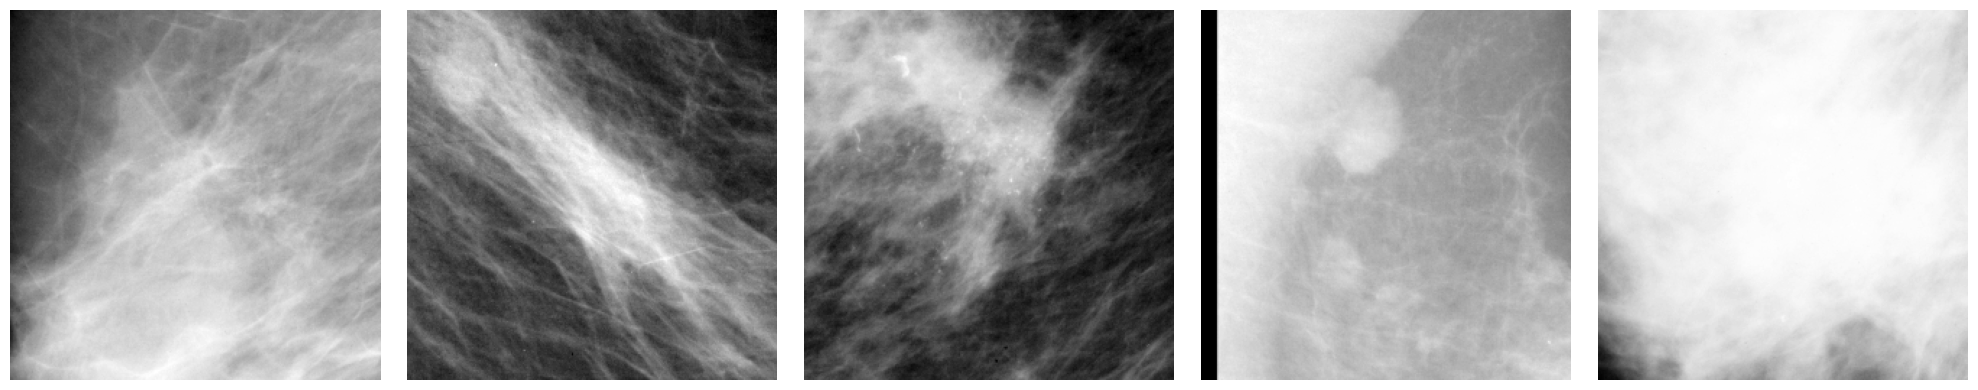

In [5]:
def visualize_random_images(images, num_images=5):
    selected_images = random.sample(list(images), num_images)
    
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar las imágenes
(x_train, _), _ = load_mias_data()

# Visualizar 10 imágenes aleatorias
visualize_random_images(x_train)

In [6]:
(x_train, _), (_, _) = load_mias_data()
x_train = x_train.astype('float32') / 255.0

In [8]:
def generator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(128,)),
            layers.Dense(256, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(1024, activation="relu"),
            layers.Dense(256 * 256, activation="sigmoid"),
            layers.Reshape((256, 256)),
        ]
    )
    return model

In [9]:
def discriminator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(256, 256)),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model

In [10]:
generator = generator()
discriminator = discriminator()

In [11]:
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
z = layers.Input(shape=(128,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

In [13]:
combined = keras.Model(z, validity)
combined.compile(optimizer="adam", loss="binary_crossentropy")

In [14]:
def train(epochs, batch_size=128):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 128))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 128))
        g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")


In [15]:
train(epochs=100, batch_size=128)

4/4 [==============================] - 1s 65ms/step


0/100 [D loss: 88.77765536308289 | D accuracy: 0.015625] [G loss: 9.634025687128324e-15]
4/4 [==============================] - 0s 61ms/step
1/100 [D loss: 1.443442232060277e-10 | D accuracy: 1.0] [G loss: 49.67250442504883]
4/4 [==============================] - 0s 67ms/step
2/100 [D loss: 31.218231081962585 | D accuracy: 0.0] [G loss: 1.5785502195358276]
4/4 [==============================] - 0s 70ms/step
3/100 [D loss: 17.408030152320862 | D accuracy: 0.0] [G loss: 1.2445116551879076e-12]
4/4 [==============================] - 0s 68ms/step
4/100 [D loss: 13.453902244977403 | D accuracy: 0.5] [G loss: 0.3785410225391388]
4/4 [==============================] - 0s 62ms/step
5/100 [D loss: 8.147786140441895 | D accuracy: 0.0] [G loss: 4.940317153930664]
4/4 [==============================] - 0s 72ms/step
6/100 [D loss: 12.559897422790527 | D accuracy: 0.0] [G loss: 2.7555007934570312]
4/4 [==============================] - 0s 52ms/st

1/1 [==============================] - 0s 132ms/step


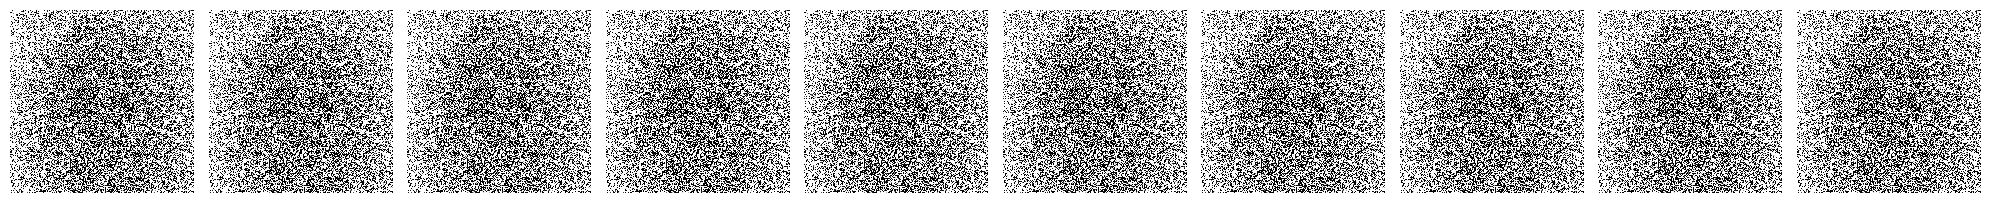

In [16]:
def generate_and_visualize_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 128))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_and_visualize_images(generator, num_images=10)